<a href="https://colab.research.google.com/github/so-yeon-hwang/DataSciencePractice/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Basic Settings

In [ ]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch                                      # 파이토치 임포트
import torch.nn as nn                             # nn 모듈 임포트
import torch.nn.functional as F

import torchvision                                # torchvision 임포트
import torchvision.utils as utils
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # pytorch에 내장된 dataset을 불러오기 위한 모듈

from tqdm import tqdm

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.
print("Torchvision: ", torchvision.__version__)   # 토치비전 버전을 확인하도록 한다.


Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Numpy: 1.25.2
Torch:  2.2.1+cu121
Torchvision:  0.17.1+cu121


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


In [ ]:
torch.cuda.is_available()

True

In [ ]:
# 하이퍼파라미터 설정

BATCH_SIZE = 256
learning_rate=0.0002
EPOCHS = 50

noise_dim = 100

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'


# PIL image (H x W x C) -> torch tensor (C x H x W) and
# [0, 255] -> [0.0, 1.0]
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = MNIST(download_root,
                      transform=mnist_transform,
                      train=True,
                      download=True)

test_dataset = MNIST(download_root,
                     transform=mnist_transform,
                     train=False,
                     download=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 4996592.43it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134666.74it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1112081.32it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4106602.45it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



In [ ]:
def print_MNIST_dataset_info(dataset):
  print(">>> dataset length: ", len(dataset))
  print(">>> type of each data: ", type(dataset[0]))
  first_img, first_label = dataset[0]
  print(">>> image shape: ", first_img.shape)
  print(">>> image dtype: ", first_img.dtype)
  print(">>> image pixel min-value: ", first_img.min())
  print(">>> image pixel max-value: ", first_img.max())
  print(">>> label data type: ", type(first_label))

print("train dataset")
print_MNIST_dataset_info(train_dataset)

print("test dataset")
print_MNIST_dataset_info(test_dataset)

train dataset
>>> dataset length:  60000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(-1.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>
test dataset
>>> dataset length:  10000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(-1.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>


In [ ]:
from torch.utils.data import DataLoader

# dataloader 정의
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [ ]:
def print_MNIST_data_loader_info(data_loader):
  print(">>> dataset length: ", len(data_loader))
  print(">>> batch_size: ", data_loader.batch_size)
  batch_images, batch_labels = next(iter(train_loader))
  # batch size로 묶은 data 이미지의 형태 확인
  print(">>> batch_images type", type(batch_images))
  print(">>> batch_images shape", batch_images.shape)
  print(">>> batch_images dtype", batch_images.dtype)

print("train dataset")
print_MNIST_data_loader_info(train_loader)

train dataset
>>> dataset length:  235
>>> batch_size:  256
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([256, 1, 28, 28])
>>> batch_images dtype torch.float32


## TODO 01

- Generator

In [ ]:
import torch
import torch.nn as nn

class CondGenerator(nn.Module):
    def __init__(self):
        super(CondGenerator, self).__init__()
        self.label_embedding = nn.Embedding(10, 50)  # 10 classes, embedding dimension is 50

        # Total input dimension is noise_dim (100) + label_embedding_dim (50)
        self.linear = nn.Linear(150, 7*7*256, bias=False)
        self.bn1 = nn.BatchNorm1d(7*7*256)
        self.convt1 = nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2, output_padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.convt2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, output_padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.convt3 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, output_padding=0, bias=False)

        self.lrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def generator(self, z, c):
        # Convert labels to long tensor and embed
        c = self.label_embedding(c.long())  # Ensure c is a LongTensor
        x = torch.cat([z, c], dim=1)  # Concatenate noise and label embedding

        x = self.lrelu(self.bn1(self.linear(x))).reshape(-1, 256, 7, 7)
        x = self.lrelu(self.bn2(self.convt1(x)))
        x = self.lrelu(self.bn3(self.convt2(x)))
        x = self.tanh(self.convt3(x))
        return x

    def forward(self, z, c):
        return self.generator(z, c)

# Assuming the device and test_noise setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = CondGenerator().to(device)


In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary

batch_size = 256  # Assuming a batch size of 256
summary(G, input_size=[(batch_size, 100), (batch_size,)], device=str(device))

Layer (type:depth-idx)                   Output Shape              Param #
CondGenerator                            [256, 1, 28, 28]          --
├─Embedding: 1-1                         [256, 50]                 500
├─Linear: 1-2                            [256, 12544]              1,881,600
├─BatchNorm1d: 1-3                       [256, 12544]              25,088
├─LeakyReLU: 1-4                         [256, 12544]              --
├─ConvTranspose2d: 1-5                   [256, 128, 7, 7]          819,200
├─BatchNorm2d: 1-6                       [256, 128, 7, 7]          256
├─LeakyReLU: 1-7                         [256, 128, 7, 7]          --
├─ConvTranspose2d: 1-8                   [256, 64, 14, 14]         131,072
├─BatchNorm2d: 1-9                       [256, 64, 14, 14]         128
├─LeakyReLU: 1-10                        [256, 64, 14, 14]         --
├─ConvTranspose2d: 1-11                  [256, 1, 28, 28]          1,024
├─Tanh: 1-12                             [256, 1, 28, 28] 

- Discriminator

In [ ]:
import torch
import torch.nn as nn

class CondDiscriminator(nn.Module):
    def __init__(self):
        super(CondDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(10, 28 * 28)  # 10 classes, embedding size matches the image area

        self.conv1 = nn.Conv2d(2, 64, (4, 4), stride=(2, 2), padding=1, bias=False)  # Input channels: 2 (1 image + 1 label channel)
        self.conv2 = nn.Conv2d(64, 128, (4, 4), stride=(2, 2), padding=1, bias=False)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(7 * 7 * 128, 1, bias=False)

        self.lrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)

    def discriminator(self, z, c):
        # Embed the labels and reshape to match image dimensions (batch_size, 1, 28, 28)
        c = self.label_embedding(c.long()).view(-1, 1, 28, 28)
        # Concatenate label channel with the image along the channel dimension
        z = torch.cat([z, c], dim=1)

        z = self.dropout(self.lrelu(self.conv1(z)))
        z = self.dropout(self.lrelu(self.conv2(z)))
        z = self.flatten(z)
        z = self.sigmoid(self.linear(z))
        return z

    def forward(self, z, c):
        return self.discriminator(z, c)

# Assuming the device is already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D = CondDiscriminator().to(device)


In [ ]:
batch_size = 256  # 배치 크기 설정
summary(D, input_size=[(batch_size, 1, 28, 28), (batch_size,)], device=str(device))


Layer (type:depth-idx)                   Output Shape              Param #
CondDiscriminator                        [256, 1]                  --
├─Embedding: 1-1                         [256, 784]                7,840
├─Conv2d: 1-2                            [256, 64, 14, 14]         2,048
├─LeakyReLU: 1-3                         [256, 64, 14, 14]         --
├─Dropout: 1-4                           [256, 64, 14, 14]         --
├─Conv2d: 1-5                            [256, 128, 7, 7]          131,072
├─LeakyReLU: 1-6                         [256, 128, 7, 7]          --
├─Dropout: 1-7                           [256, 128, 7, 7]          --
├─Flatten: 1-8                           [256, 6272]               --
├─Linear: 1-9                            [256, 1]                  6,272
├─Sigmoid: 1-10                          [256, 1]                  --
Total params: 147,232
Trainable params: 147,232
Non-trainable params: 0
Total mult-adds (G): 1.75
Input size (MB): 0.80
Forward/backward pass

In [ ]:
# Test with a batch of noise vectors and labels
test_noise = torch.randn(64, 100).to(device)  # 64 is the batch size, 100 is the noise dimension
test_labels = torch.randint(0, 10, (64,)).to(device)  # Random labels for each image in the batch

G.eval()

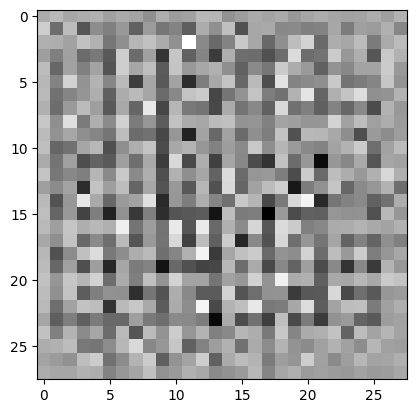

In [ ]:
import torch
import matplotlib.pyplot as plt

G.eval()

# 노이즈 벡터 생성 (예시로 1개의 이미지 생성)
test_noise = torch.randn(1, 100).to(device)  # (1, 100) 크기의 노이즈 벡터

# 생성하고자 하는 이미지의 레이블 설정
label_index = 3  # 예시: '3'을 생성하고 싶은 경우
label_tensor = torch.tensor([label_index], dtype=torch.long).to(device)  # 레이블 텐서

# 생성기를 통해 이미지 생성
with torch.no_grad():  # 그라디언트 계산 비활성화
    fake_image = G(test_noise, label_tensor)

# 생성된 이미지 시각화
fake_image = fake_image.cpu().squeeze(0).squeeze(0)  # 첫 번째 배치와 채널 차원 제거
plt.imshow(fake_image, cmap='gray')  # 회색조로 표시


In [ ]:
# Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.
D.eval()    # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
decision = D(G(test_noise,label_tensor),label_tensor)

print(decision)

tensor([[0.5025]], device='cuda:0', grad_fn=<SigmoidBackward0>)


- Training

In [ ]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의
criterion = torch.nn.BCELoss()

# GAN 트레이닝에 쓰일 optimizer 정의
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

G = CondGenerator().to(device)
D = CondDiscriminator().to(device)

GPU is available


In [ ]:
pip install torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

## 학습코드 try 01

In [ ]:
import torch

G.train()
D.train()

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(EPOCHS):
    D_losses = []
    G_losses = []

    for i, (images, labels) in enumerate(train_loader):
        #############################
        # 1) Update discriminator D #
        #############################
        D.zero_grad()

        # 진짜 이미지와 레이블 준비
        images = images.to(device)
        labels = labels.to(device)
        y_real_pred = D(images, labels).view(-1)
        real_label = torch.full((images.size(0),), 1., dtype=torch.float, device=device)

        # Discriminator가 진짜 이미지를 진짜로 판별한 정도를 측정
        D_real_loss = criterion(y_real_pred, real_label)
        D_real_loss.backward()
        D_x = y_real_pred.mean().item()

        # 가짜 데이터 생성
        noises = torch.randn(images.size(0), noise_dim, device=device)
        fake_labels = torch.randint(0, 10, (images.size(0),), device=device)  # 무작위 레이블 생성
        images_fake = G(noises, fake_labels)

        # Discriminator가 가짜 이미지를 가짜로 판별한 정도를 측정
        y_fake_pred = D(images_fake.detach(), fake_labels).view(-1)
        fake_label = torch.zeros(images.size(0), dtype=torch.float, device=device)
        D_fake_loss = criterion(y_fake_pred, fake_label)
        D_fake_loss.backward()
        D_G_z1 = y_fake_pred.mean().item()

        D_loss = D_real_loss + D_fake_loss
        D_optimizer.step()

        #############################
        # 2) Update generator G #
        #############################
        G.zero_grad()

        # Generator가 만든 가짜 이미지를 다시 판별
        y_fake_pred = D(images_fake, fake_labels).view(-1)
        real_label.fill_(1.)  # 가짜 이미지를 진짜로 오인하도록 하기 위한 레이블

        # Generator가 가짜 이미지를 진짜로 판별받는 정도를 측정
        G_loss = criterion(y_fake_pred, real_label)
        G_loss.backward()
        D_G_z2 = y_fake_pred.mean().item()
        G_optimizer.step()

        if i % 50 == 0:
            print(f'[{epoch}/{EPOCHS}][{i}/{len(train_loader)}]\tLoss_D: {D_loss.item():.4f}\tLoss_G: {G_loss.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

    train_hist['D_losses'].append(torch.mean(torch.Tensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.Tensor(G_losses)))

print('Training Finished!')


[0/50][0/235]	Loss_D: 1.4070	Loss_G: 0.6265	D(x): 0.5271	D(G(z)): 0.5344 / 0.5350
[0/50][50/235]	Loss_D: 1.4150	Loss_G: 0.6267	D(x): 0.5252	D(G(z)): 0.5363 / 0.5349
[0/50][100/235]	Loss_D: 1.4088	Loss_G: 0.6321	D(x): 0.5267	D(G(z)): 0.5348 / 0.5320
[0/50][150/235]	Loss_D: 1.4002	Loss_G: 0.6339	D(x): 0.5284	D(G(z)): 0.5323 / 0.5311
[0/50][200/235]	Loss_D: 1.4072	Loss_G: 0.6281	D(x): 0.5256	D(G(z)): 0.5332 / 0.5342
[1/50][0/235]	Loss_D: 1.4066	Loss_G: 0.6246	D(x): 0.5266	D(G(z)): 0.5338 / 0.5359
[1/50][50/235]	Loss_D: 1.4100	Loss_G: 0.6253	D(x): 0.5283	D(G(z)): 0.5367 / 0.5356
[1/50][100/235]	Loss_D: 1.4081	Loss_G: 0.6278	D(x): 0.5274	D(G(z)): 0.5352 / 0.5343
[1/50][150/235]	Loss_D: 1.4107	Loss_G: 0.6273	D(x): 0.5270	D(G(z)): 0.5359 / 0.5346
[1/50][200/235]	Loss_D: 1.4099	Loss_G: 0.6218	D(x): 0.5263	D(G(z)): 0.5350 / 0.5375
[2/50][0/235]	Loss_D: 1.4099	Loss_G: 0.6277	D(x): 0.5285	D(G(z)): 0.5369 / 0.5344
[2/50][50/235]	Loss_D: 1.4066	Loss_G: 0.6308	D(x): 0.5285	D(G(z)): 0.5353 / 0.5327
[

In [ ]:
# Test with a batch of noise vectors and labels
test_noise = torch.randn(64, 100).to(device)  # 64 is the batch size, 100 is the noise dimension
test_labels = torch.randint(0, 10, (64,)).to(device)  # Random labels for each image in the batch

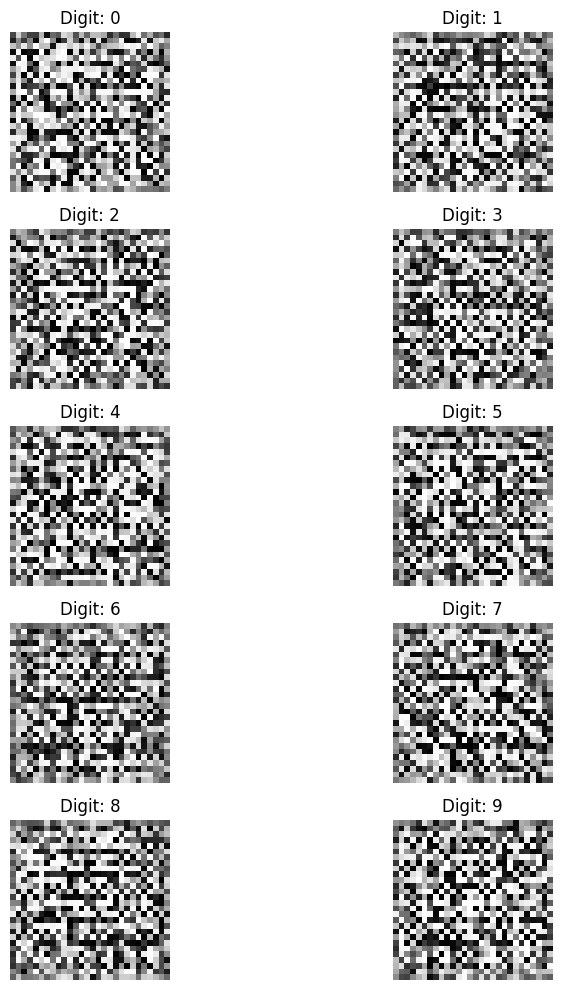

In [ ]:
import torch
import matplotlib.pyplot as plt

# 조건부 생성자 G가 이미 훈련되었다고 가정
G.eval()  # 모델을 평가 모드로 설정

# 10개의 노이즈 벡터 생성
noises = torch.randn(10, 100, device=device)

# 생성할 이미지의 레이블 설정 (0에서 9까지 각 숫자 한 개씩)
condition = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device=device)

# 생성자를 사용해 이미지 생성
generated_images = G(noises, condition).cpu().detach()

# 생성된 이미지 시각화
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # 이미지는 1x28x28 크기로 가정
    ax.imshow(generated_images[i].view(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Digit: {condition[i].item()}")

plt.tight_layout()
plt.show()


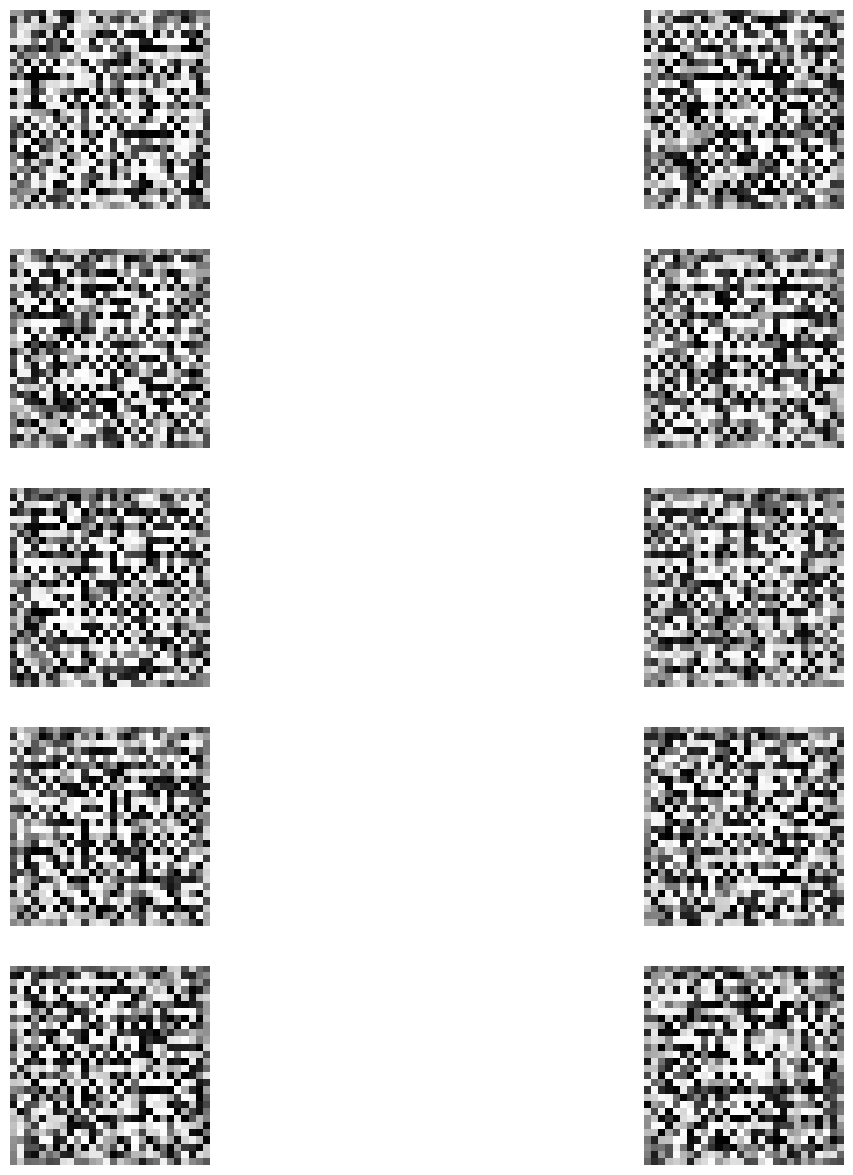

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

# 10개의 조건 설정 (0에서 9까지 무작위 숫자)
condition = torch.randint(0, 10, (10,), device=device)

# Generator 테스트
G.eval()  # 모델을 평가 모드로 설정
noises = torch.randn(10, 100, device=device)  # 10개의 노이즈 벡터 생성
# generated_images = G(noises, condition).cpu().detach().numpy().squeeze()
generated_image = G(noises,condition).cpu().detach().numpy().squeeze()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()

## 학습코드 try 02

In [ ]:
# 하이퍼파라미터 설정

BATCH_SIZE = 256
learning_rate=0.0001
EPOCHS = 10

noise_dim = 100

In [ ]:
noise_dim = 100

import torch

G.train()
D.train()

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(EPOCHS):
    D_losses = []
    G_losses = []

    for i, (images, labels) in enumerate(train_loader):
        #############################
        # 1) Update discriminator D #
        #############################
        D.zero_grad()

        # 진짜 이미지와 레이블 준비
        images = images.to(device)
        labels = labels.to(device)
        y_real_pred = D(images, labels).view(-1)
        real_label = torch.full((images.size(0),), 1., dtype=torch.float, device=device)

        # Discriminator가 진짜 이미지를 진짜로 판별한 정도를 측정
        D_real_loss = criterion(y_real_pred, real_label)
        D_real_loss.backward()
        D_x = y_real_pred.mean().item()

        # 가짜 데이터 생성
        noises = torch.randn(images.size(0), noise_dim, device=device)
        fake_labels = torch.randint(0, 10, (images.size(0),), device=device)  # 무작위 레이블 생성
        images_fake = G(noises, fake_labels)

        # Discriminator가 가짜 이미지를 가짜로 판별한 정도를 측정
        y_fake_pred = D(images_fake.detach(), fake_labels).view(-1)
        fake_label = torch.zeros(images.size(0), dtype=torch.float, device=device)
        D_fake_loss = criterion(y_fake_pred, fake_label)
        D_fake_loss.backward()
        D_G_z1 = y_fake_pred.mean().item()

        D_loss = D_real_loss + D_fake_loss
        D_optimizer.step()

        #############################
        # 2) Update generator G #
        #############################
        G.zero_grad()

        # Generator가 만든 가짜 이미지를 다시 판별
        y_fake_pred = D(images_fake, fake_labels).view(-1)
        real_label.fill_(1.)  # 가짜 이미지를 진짜로 오인하도록 하기 위한 레이블

        # Generator가 가짜 이미지를 진짜로 판별받는 정도를 측정
        G_loss = criterion(y_fake_pred, real_label)
        G_loss.backward()
        D_G_z2 = y_fake_pred.mean().item()
        G_optimizer.step()

        if i % 50 == 0:
            print(f'[{epoch}/{EPOCHS}][{i}/{len(train_loader)}]\tLoss_D: {D_loss.item():.4f}\tLoss_G: {G_loss.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

    train_hist['D_losses'].append(torch.mean(torch.Tensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.Tensor(G_losses)))

print('Training Finished!')


[0/10][0/235]	Loss_D: 1.4100	Loss_G: 0.6282	D(x): 0.5280	D(G(z)): 0.5364 / 0.5341
[0/10][50/235]	Loss_D: 1.3983	Loss_G: 0.6311	D(x): 0.5298	D(G(z)): 0.5328 / 0.5325
[0/10][100/235]	Loss_D: 1.4086	Loss_G: 0.6311	D(x): 0.5263	D(G(z)): 0.5342 / 0.5325
[0/10][150/235]	Loss_D: 1.4013	Loss_G: 0.6256	D(x): 0.5293	D(G(z)): 0.5336 / 0.5355
[0/10][200/235]	Loss_D: 1.4070	Loss_G: 0.6291	D(x): 0.5262	D(G(z)): 0.5335 / 0.5336
[1/10][0/235]	Loss_D: 1.3995	Loss_G: 0.6292	D(x): 0.5286	D(G(z)): 0.5322 / 0.5336
[1/10][50/235]	Loss_D: 1.4086	Loss_G: 0.6285	D(x): 0.5264	D(G(z)): 0.5345 / 0.5340
[1/10][100/235]	Loss_D: 1.4009	Loss_G: 0.6249	D(x): 0.5290	D(G(z)): 0.5332 / 0.5359
[1/10][150/235]	Loss_D: 1.3984	Loss_G: 0.6256	D(x): 0.5280	D(G(z)): 0.5311 / 0.5355
[1/10][200/235]	Loss_D: 1.4135	Loss_G: 0.6274	D(x): 0.5263	D(G(z)): 0.5367 / 0.5345
[2/10][0/235]	Loss_D: 1.4129	Loss_G: 0.6281	D(x): 0.5243	D(G(z)): 0.5344 / 0.5341
[2/10][50/235]	Loss_D: 1.4151	Loss_G: 0.6311	D(x): 0.5231	D(G(z)): 0.5344 / 0.5326
[

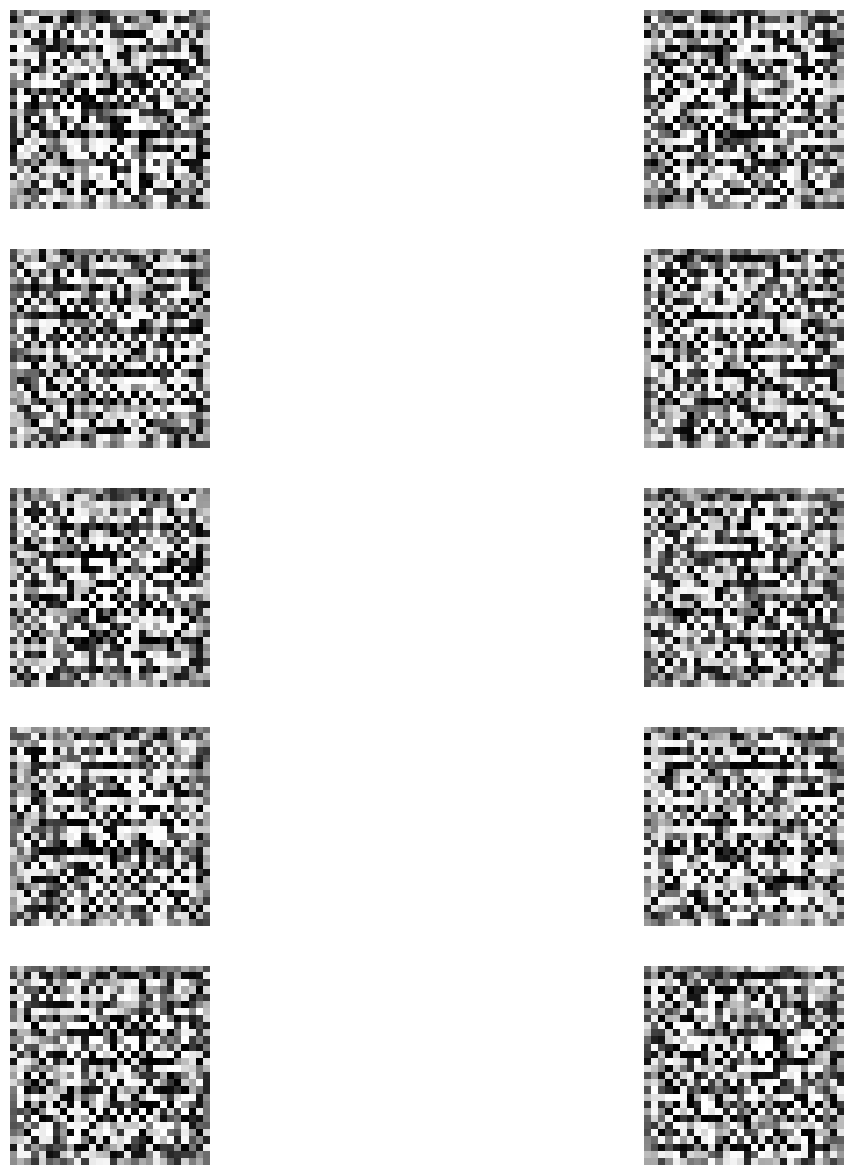

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

# 10개의 조건 설정 (0에서 9까지 무작위 숫자)
condition = torch.randint(0, 10, (10,), device=device)

# Generator 테스트
G.eval()  # 모델을 평가 모드로 설정
noises = torch.randn(10, 100, device=device)  # 10개의 노이즈 벡터 생성
# generated_images = G(noises, condition).cpu().detach().numpy().squeeze()
generated_image = G(noises,condition).cpu().detach().numpy().squeeze()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()

## 학습코드 try 03

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision.utils import save_image

# 하이퍼파라미터 설정
BATCH_SIZE = 256
lr_D = 0.0002  # 판별자의 학습률
lr_G = 0.0001  # 생성자의 학습률
EPOCHS = 10
noise_dim = 100

# 옵티마이저 설정
D_optimizer = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.999))

# 손실 함수
criterion = nn.BCELoss()

# 훈련
G.train()
D.train()

train_hist = {'D_losses': [], 'G_losses': []}

for epoch in range(EPOCHS):
    D_losses = []
    G_losses = []

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 진짜 이미지에 대한 판별자의 손실 계산
        D.zero_grad()
        real_labels = torch.full((images.size(0),), 0.9, device=device)  # 라벨 스무딩 적용
        outputs = D(images, labels).view(-1)
        D_loss_real = criterion(outputs, real_labels)
        D_x = outputs.mean().item()

        # 가짜 이미지 생성 및 판별자 손실 계산
        noise = torch.randn(images.size(0), noise_dim, device=device)
        fake_labels = torch.randint(0, 10, (images.size(0),), device=device)
        fake_images = G(noise, fake_labels)
        fake_outputs = D(fake_images.detach(), fake_labels).view(-1)
        fake_labels = torch.zeros(images.size(0), device=device)  # 가짜 이미지 레이블
        D_loss_fake = criterion(fake_outputs, fake_labels)
        D_G_z1 = fake_outputs.mean().item()

        # 판별자 업데이트
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        # 생성자의 손실 계산 및 업데이트
        G.zero_grad()
        labels = torch.full((images.size(0),), 1.0, device=device, dtype=torch.float)  # 생성자에게는 모두 진짜라고 속임
        outputs = D(fake_images, fake_labels).view(-1)
        G_loss = criterion(outputs, labels)
        G_loss.backward()
        G_optimizer.step()
        D_G_z2 = outputs.mean().item()

        if i % 50 == 0:
            print(f'[{epoch}/{EPOCHS}][{i}/{len(train_loader)}] Loss_D: {D_loss.item():.4f} Loss_G: {G_loss.item():.4f} D(x): {D_x:.4f} D(G(z1)): {D_G_z1:.4f} / D(G(z2)): {D_G_z2:.4f}')

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))

print('Training Finished!')


[0/10][0/235] Loss_D: 0.3466 Loss_G: 4.4020 D(x): 0.8906 D(G(z1)): 0.0087 / D(G(z2)): 0.0133
[0/10][50/235] Loss_D: 0.3367 Loss_G: 5.9130 D(x): 0.8880 D(G(z1)): 0.0018 / D(G(z2)): 0.0029
[0/10][100/235] Loss_D: 0.3709 Loss_G: 4.8336 D(x): 0.9267 D(G(z1)): 0.0214 / D(G(z2)): 0.0092
[0/10][150/235] Loss_D: 1.3823 Loss_G: 0.6661 D(x): 0.4108 D(G(z1)): 0.3258 / D(G(z2)): 0.5299
[0/10][200/235] Loss_D: 1.1787 Loss_G: 0.9353 D(x): 0.4890 D(G(z1)): 0.3369 / D(G(z2)): 0.4116
[1/10][0/235] Loss_D: 0.9157 Loss_G: 0.9654 D(x): 0.6391 D(G(z1)): 0.3052 / D(G(z2)): 0.4092
[1/10][50/235] Loss_D: 0.7654 Loss_G: 0.8097 D(x): 0.6866 D(G(z1)): 0.2283 / D(G(z2)): 0.4712
[1/10][100/235] Loss_D: 0.6530 Loss_G: 0.6002 D(x): 0.7451 D(G(z1)): 0.1691 / D(G(z2)): 0.5813
[1/10][150/235] Loss_D: 0.5468 Loss_G: 0.5923 D(x): 0.8064 D(G(z1)): 0.1093 / D(G(z2)): 0.5927
[1/10][200/235] Loss_D: 0.5737 Loss_G: 0.4714 D(x): 0.8210 D(G(z1)): 0.1321 / D(G(z2)): 0.6521
[2/10][0/235] Loss_D: 0.5618 Loss_G: 0.3476 D(x): 0.7421

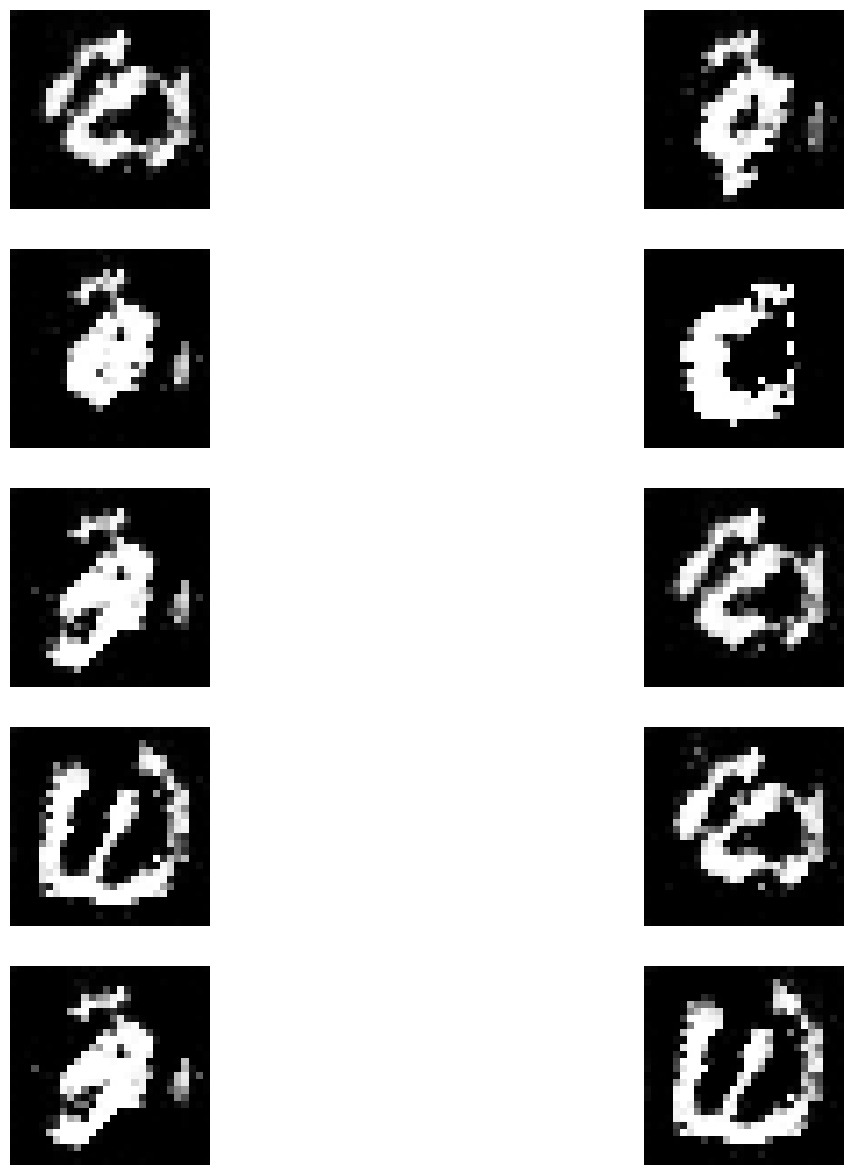

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

# 10개의 조건 설정 (0에서 9까지 무작위 숫자)
condition = torch.randint(0, 10, (10,), device=device)

# Generator 테스트
G.eval()  # 모델을 평가 모드로 설정
noises = torch.randn(10, 100, device=device)  # 10개의 노이즈 벡터 생성
# generated_images = G(noises, condition).cpu().detach().numpy().squeeze()
generated_image = G(noises,condition).cpu().detach().numpy().squeeze()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()

## 학습코드 try 04

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision.utils import save_image

# 하이퍼파라미터 설정
BATCH_SIZE = 256
lr_D = 0.0002  # 판별자의 학습률
lr_G = 0.0001  # 생성자의 학습률
EPOCHS = 50
noise_dim = 100

# 옵티마이저 설정
D_optimizer = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.999))

# 손실 함수
criterion = nn.BCELoss()

# 훈련
G.train()
D.train()

train_hist = {'D_losses': [], 'G_losses': []}

for epoch in range(EPOCHS):
    D_losses = []
    G_losses = []

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 진짜 이미지에 대한 판별자의 손실 계산
        D.zero_grad()
        real_labels = torch.full((images.size(0),), 0.9, device=device)  # 라벨 스무딩 적용
        outputs = D(images, labels).view(-1)
        D_loss_real = criterion(outputs, real_labels)
        D_x = outputs.mean().item()

        # 가짜 이미지 생성 및 판별자 손실 계산
        noise = torch.randn(images.size(0), noise_dim, device=device)
        fake_labels = torch.randint(0, 10, (images.size(0),), device=device)
        fake_images = G(noise, fake_labels)
        fake_outputs = D(fake_images.detach(), fake_labels).view(-1)
        fake_labels = torch.zeros(images.size(0), device=device)  # 가짜 이미지 레이블
        D_loss_fake = criterion(fake_outputs, fake_labels)
        D_G_z1 = fake_outputs.mean().item()

        # 판별자 업데이트
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        # 생성자의 손실 계산 및 업데이트
        G.zero_grad()
        labels = torch.full((images.size(0),), 1.0, device=device, dtype=torch.float)  # 생성자에게는 모두 진짜라고 속임
        outputs = D(fake_images, fake_labels).view(-1)
        G_loss = criterion(outputs, labels)
        G_loss.backward()
        G_optimizer.step()
        D_G_z2 = outputs.mean().item()

        if i % 50 == 0:
            print(f'[{epoch}/{EPOCHS}][{i}/{len(train_loader)}] Loss_D: {D_loss.item():.4f} Loss_G: {G_loss.item():.4f} D(x): {D_x:.4f} D(G(z1)): {D_G_z1:.4f} / D(G(z2)): {D_G_z2:.4f}')

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))

print('Training Finished!')


[0/50][0/235] Loss_D: 0.3751 Loss_G: 0.3386 D(x): 0.8864 D(G(z1)): 0.0222 / D(G(z2)): 0.8654
[0/50][50/235] Loss_D: 0.4319 Loss_G: 0.5324 D(x): 0.8665 D(G(z1)): 0.0486 / D(G(z2)): 0.6932
[0/50][100/235] Loss_D: 0.3934 Loss_G: 0.2369 D(x): 0.8681 D(G(z1)): 0.0194 / D(G(z2)): 0.8593
[0/50][150/235] Loss_D: 0.3865 Loss_G: 0.2325 D(x): 0.8667 D(G(z1)): 0.0168 / D(G(z2)): 0.8857
[0/50][200/235] Loss_D: 0.3736 Loss_G: 0.2902 D(x): 0.8872 D(G(z1)): 0.0160 / D(G(z2)): 0.8827
[1/50][0/235] Loss_D: 0.4545 Loss_G: 0.4663 D(x): 0.9053 D(G(z1)): 0.0793 / D(G(z2)): 0.7783
[1/50][50/235] Loss_D: 0.3836 Loss_G: 0.2548 D(x): 0.8842 D(G(z1)): 0.0203 / D(G(z2)): 0.8860
[1/50][100/235] Loss_D: 0.3615 Loss_G: 0.2886 D(x): 0.8965 D(G(z1)): 0.0144 / D(G(z2)): 0.8807
[1/50][150/235] Loss_D: 0.3719 Loss_G: 0.3475 D(x): 0.8866 D(G(z1)): 0.0176 / D(G(z2)): 0.8341
[1/50][200/235] Loss_D: 0.3960 Loss_G: 0.3776 D(x): 0.8713 D(G(z1)): 0.0226 / D(G(z2)): 0.7944
[2/50][0/235] Loss_D: 0.4004 Loss_G: 0.3301 D(x): 0.9071

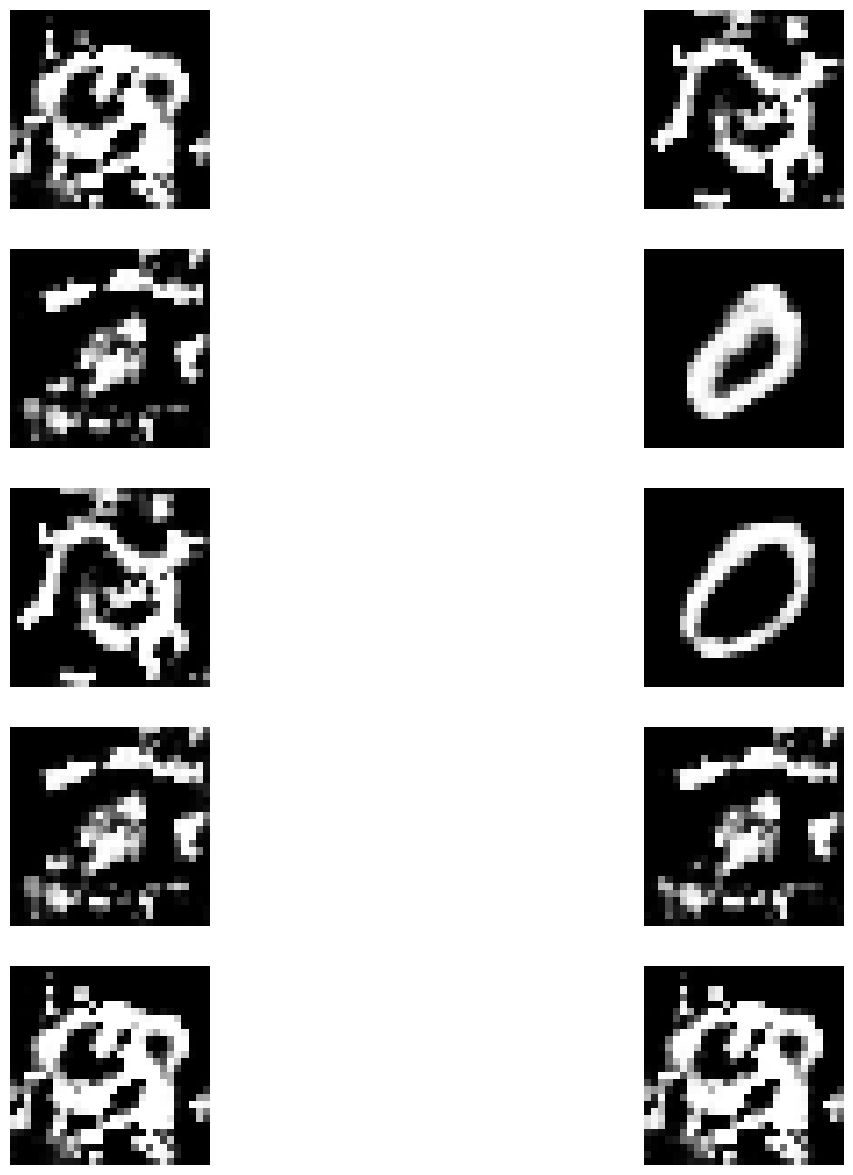

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

# 10개의 조건 설정 (0에서 9까지 무작위 숫자)
condition = torch.randint(0, 10, (10,), device=device)

# Generator 테스트
G.eval()  # 모델을 평가 모드로 설정
noises = torch.randn(10, 100, device=device)  # 10개의 노이즈 벡터 생성
# generated_images = G(noises, condition).cpu().detach().numpy().squeeze()
generated_image = G(noises,condition).cpu().detach().numpy().squeeze()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()

## 학습코드 try 05

In [ ]:
import torch
import torch.nn as nn

class CondGenerator(nn.Module):
    def __init__(self):
        super(CondGenerator, self).__init__()
        self.label_embedding = nn.Embedding(10, 50)  # 10 classes, embedding dimension is 50

        # Total input dimension is noise_dim (200) + label_embedding_dim (50)
        self.linear = nn.Linear(250, 7*7*256, bias=False)
        self.bn1 = nn.BatchNorm1d(7*7*256)
        self.convt1 = nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2, output_padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.convt2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, output_padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.convt3 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, output_padding=0, bias=False)

        self.lrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def generator(self, z, c):
        # Convert labels to long tensor and embed
        c = self.label_embedding(c.long())  # Ensure c is a LongTensor
        x = torch.cat([z, c], dim=1)  # Concatenate noise and label embedding

        x = self.lrelu(self.bn1(self.linear(x))).reshape(-1, 256, 7, 7)
        x = self.lrelu(self.bn2(self.convt1(x)))
        x = self.lrelu(self.bn3(self.convt2(x)))
        x = self.tanh(self.convt3(x))
        return x

    def forward(self, z, c):
        return self.generator(z, c)

# Assuming the device and test_noise setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = CondGenerator().to(device)


In [ ]:
import torch
import torch.nn as nn

class CondDiscriminator(nn.Module):
    def __init__(self):
        super(CondDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(10, 28 * 28)  # 10 classes, embedding size matches the image area

        self.conv1 = nn.Conv2d(2, 64, (4, 4), stride=(2, 2), padding=1, bias=False)  # Input channels: 2 (1 image + 1 label channel)
        self.conv2 = nn.Conv2d(64, 128, (4, 4), stride=(2, 2), padding=1, bias=False)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(7 * 7 * 128, 1, bias=False)

        self.lrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)

    def discriminator(self, z, c):
        # Embed the labels and reshape to match image dimensions (batch_size, 1, 28, 28)
        c = self.label_embedding(c.long()).view(-1, 1, 28, 28)
        # Concatenate label channel with the image along the channel dimension
        z = torch.cat([z, c], dim=1)

        z = self.dropout(self.lrelu(self.conv1(z)))
        z = self.dropout(self.lrelu(self.conv2(z)))
        z = self.flatten(z)
        z = self.sigmoid(self.linear(z))
        return z

    def forward(self, z, c):
        return self.discriminator(z, c)

# Assuming the device is already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D = CondDiscriminator().to(device)


[0/100][0/235] Loss_D: 1.4008 Loss_G: 0.7994 D(x): 0.4871 D(G(z1)): 0.4957 / D(G(z2)): 0.4501
[0/100][50/235] Loss_D: 0.3549 Loss_G: 3.9013 D(x): 0.8829 D(G(z1)): 0.0104 / D(G(z2)): 0.0210
[0/100][100/235] Loss_D: 0.7464 Loss_G: 1.0836 D(x): 0.6488 D(G(z1)): 0.1163 / D(G(z2)): 0.3495
[0/100][150/235] Loss_D: 0.5183 Loss_G: 2.2200 D(x): 0.8298 D(G(z1)): 0.0973 / D(G(z2)): 0.1165
[0/100][200/235] Loss_D: 1.9506 Loss_G: 0.6167 D(x): 0.2889 D(G(z1)): 0.5144 / D(G(z2)): 0.5446


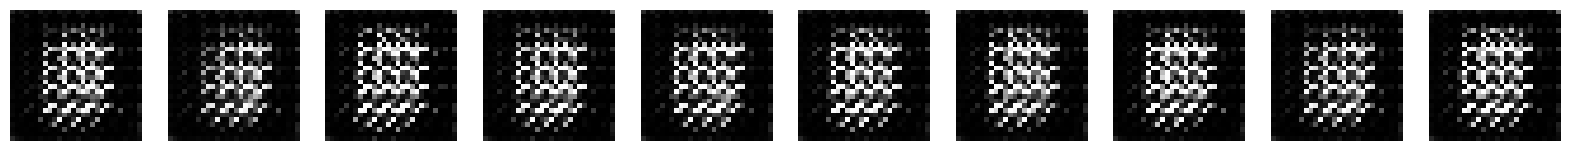

[1/100][0/235] Loss_D: 1.0191 Loss_G: 1.2004 D(x): 0.5987 D(G(z1)): 0.3573 / D(G(z2)): 0.3076
[1/100][50/235] Loss_D: 1.0933 Loss_G: 1.1725 D(x): 0.5605 D(G(z1)): 0.3554 / D(G(z2)): 0.3180
[1/100][100/235] Loss_D: 1.0766 Loss_G: 0.9888 D(x): 0.5575 D(G(z1)): 0.3508 / D(G(z2)): 0.3879
[1/100][150/235] Loss_D: 0.8431 Loss_G: 0.9214 D(x): 0.6763 D(G(z1)): 0.2780 / D(G(z2)): 0.4181
[1/100][200/235] Loss_D: 0.7480 Loss_G: 0.8819 D(x): 0.7268 D(G(z1)): 0.2369 / D(G(z2)): 0.4334
[2/100][0/235] Loss_D: 0.7580 Loss_G: 0.8802 D(x): 0.7784 D(G(z1)): 0.2633 / D(G(z2)): 0.4350
[2/100][50/235] Loss_D: 0.5713 Loss_G: 0.6451 D(x): 0.7774 D(G(z1)): 0.1093 / D(G(z2)): 0.5738
[2/100][100/235] Loss_D: 0.5338 Loss_G: 0.4730 D(x): 0.8138 D(G(z1)): 0.1059 / D(G(z2)): 0.6633
[2/100][150/235] Loss_D: 0.5306 Loss_G: 0.5198 D(x): 0.8184 D(G(z1)): 0.0845 / D(G(z2)): 0.6343
[2/100][200/235] Loss_D: 0.5073 Loss_G: 0.4219 D(x): 0.8289 D(G(z1)): 0.0663 / D(G(z2)): 0.6904
[3/100][0/235] Loss_D: 0.5655 Loss_G: 0.3971 D

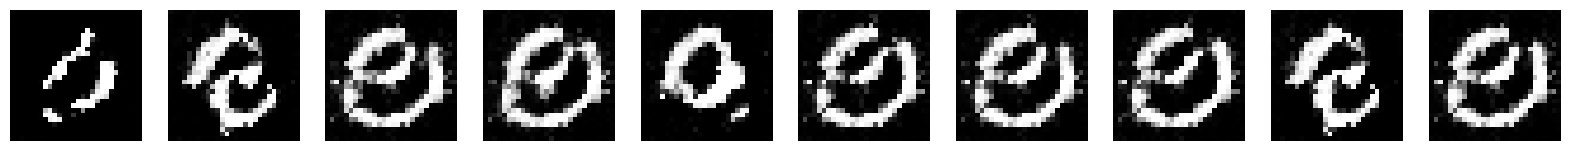

[11/100][0/235] Loss_D: 0.3777 Loss_G: 0.2451 D(x): 0.8849 D(G(z1)): 0.0205 / D(G(z2)): 0.8811
[11/100][50/235] Loss_D: 0.4122 Loss_G: 0.1517 D(x): 0.8484 D(G(z1)): 0.0264 / D(G(z2)): 0.9052
[11/100][100/235] Loss_D: 0.4041 Loss_G: 0.2901 D(x): 0.8683 D(G(z1)): 0.0316 / D(G(z2)): 0.8444
[11/100][150/235] Loss_D: 0.3885 Loss_G: 0.1910 D(x): 0.8653 D(G(z1)): 0.0220 / D(G(z2)): 0.8863
[11/100][200/235] Loss_D: 0.4469 Loss_G: 0.2230 D(x): 0.8723 D(G(z1)): 0.0409 / D(G(z2)): 0.8415
[12/100][0/235] Loss_D: 0.4321 Loss_G: 0.3165 D(x): 0.8679 D(G(z1)): 0.0445 / D(G(z2)): 0.8278
[12/100][50/235] Loss_D: 0.3882 Loss_G: 0.1697 D(x): 0.8743 D(G(z1)): 0.0258 / D(G(z2)): 0.8873
[12/100][100/235] Loss_D: 0.3927 Loss_G: 0.2458 D(x): 0.8632 D(G(z1)): 0.0230 / D(G(z2)): 0.8478
[12/100][150/235] Loss_D: 0.3823 Loss_G: 0.1279 D(x): 0.8837 D(G(z1)): 0.0220 / D(G(z2)): 0.9302
[12/100][200/235] Loss_D: 0.4235 Loss_G: 0.2063 D(x): 0.8603 D(G(z1)): 0.0249 / D(G(z2)): 0.8631
[13/100][0/235] Loss_D: 0.4283 Loss_

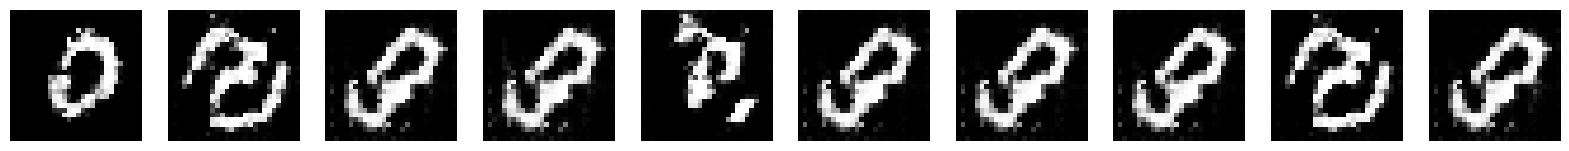

[21/100][0/235] Loss_D: 0.4123 Loss_G: 0.2002 D(x): 0.8807 D(G(z1)): 0.0272 / D(G(z2)): 0.8647
[21/100][50/235] Loss_D: 0.3756 Loss_G: 0.3384 D(x): 0.8866 D(G(z1)): 0.0244 / D(G(z2)): 0.8537
[21/100][100/235] Loss_D: 0.3959 Loss_G: 0.2849 D(x): 0.8844 D(G(z1)): 0.0347 / D(G(z2)): 0.8442
[21/100][150/235] Loss_D: 0.3750 Loss_G: 0.3168 D(x): 0.8648 D(G(z1)): 0.0178 / D(G(z2)): 0.8508
[21/100][200/235] Loss_D: 0.3586 Loss_G: 0.4746 D(x): 0.8943 D(G(z1)): 0.0119 / D(G(z2)): 0.8217
[22/100][0/235] Loss_D: 0.3841 Loss_G: 0.1727 D(x): 0.8896 D(G(z1)): 0.0225 / D(G(z2)): 0.8829
[22/100][50/235] Loss_D: 0.3791 Loss_G: 0.2490 D(x): 0.8771 D(G(z1)): 0.0217 / D(G(z2)): 0.8701
[22/100][100/235] Loss_D: 0.3667 Loss_G: 0.1996 D(x): 0.8767 D(G(z1)): 0.0155 / D(G(z2)): 0.8957
[22/100][150/235] Loss_D: 0.3704 Loss_G: 0.1692 D(x): 0.8883 D(G(z1)): 0.0197 / D(G(z2)): 0.9194
[22/100][200/235] Loss_D: 0.3676 Loss_G: 0.3209 D(x): 0.8912 D(G(z1)): 0.0172 / D(G(z2)): 0.8678
[23/100][0/235] Loss_D: 0.3811 Loss_

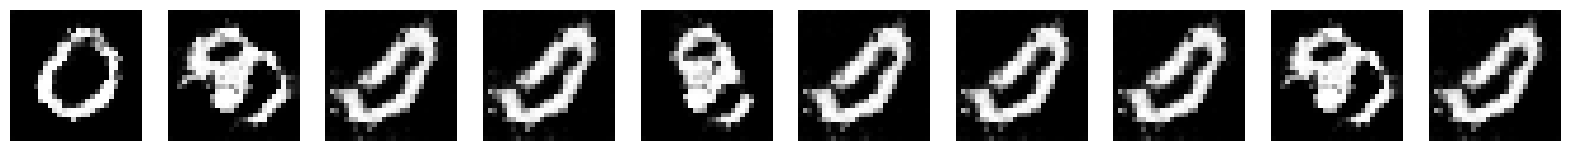

[31/100][0/235] Loss_D: 0.3629 Loss_G: 0.1900 D(x): 0.9015 D(G(z1)): 0.0182 / D(G(z2)): 0.9111
[31/100][50/235] Loss_D: 0.3659 Loss_G: 0.4028 D(x): 0.8933 D(G(z1)): 0.0162 / D(G(z2)): 0.8381
[31/100][100/235] Loss_D: 0.3787 Loss_G: 0.2931 D(x): 0.8844 D(G(z1)): 0.0164 / D(G(z2)): 0.8709
[31/100][150/235] Loss_D: 0.3566 Loss_G: 0.2203 D(x): 0.8807 D(G(z1)): 0.0066 / D(G(z2)): 0.8863
[31/100][200/235] Loss_D: 0.3746 Loss_G: 0.3564 D(x): 0.8997 D(G(z1)): 0.0281 / D(G(z2)): 0.8558
[32/100][0/235] Loss_D: 0.3551 Loss_G: 0.2305 D(x): 0.8875 D(G(z1)): 0.0049 / D(G(z2)): 0.9098
[32/100][50/235] Loss_D: 0.3795 Loss_G: 0.2467 D(x): 0.8781 D(G(z1)): 0.0142 / D(G(z2)): 0.8912
[32/100][100/235] Loss_D: 0.3543 Loss_G: 0.3635 D(x): 0.8931 D(G(z1)): 0.0088 / D(G(z2)): 0.8736
[32/100][150/235] Loss_D: 0.3847 Loss_G: 0.4443 D(x): 0.8745 D(G(z1)): 0.0188 / D(G(z2)): 0.7751
[32/100][200/235] Loss_D: 0.3837 Loss_G: 0.2083 D(x): 0.8882 D(G(z1)): 0.0142 / D(G(z2)): 0.9186
[33/100][0/235] Loss_D: 0.3620 Loss_

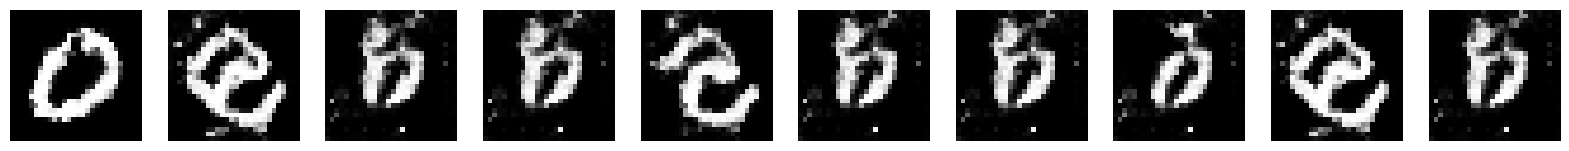

[41/100][0/235] Loss_D: 0.3623 Loss_G: 0.3275 D(x): 0.8871 D(G(z1)): 0.0137 / D(G(z2)): 0.8631
[41/100][50/235] Loss_D: 0.3876 Loss_G: 0.2325 D(x): 0.8786 D(G(z1)): 0.0219 / D(G(z2)): 0.8906
[41/100][100/235] Loss_D: 0.3574 Loss_G: 0.3324 D(x): 0.8925 D(G(z1)): 0.0055 / D(G(z2)): 0.9060
[41/100][150/235] Loss_D: 0.3521 Loss_G: 0.4314 D(x): 0.8927 D(G(z1)): 0.0089 / D(G(z2)): 0.8578
[41/100][200/235] Loss_D: 0.3596 Loss_G: 0.2213 D(x): 0.9009 D(G(z1)): 0.0210 / D(G(z2)): 0.9041
[42/100][0/235] Loss_D: 0.3549 Loss_G: 0.3483 D(x): 0.8947 D(G(z1)): 0.0147 / D(G(z2)): 0.8456
[42/100][50/235] Loss_D: 0.3522 Loss_G: 0.3946 D(x): 0.8925 D(G(z1)): 0.0062 / D(G(z2)): 0.8516
[42/100][100/235] Loss_D: 0.3512 Loss_G: 0.4623 D(x): 0.8965 D(G(z1)): 0.0097 / D(G(z2)): 0.8353
[42/100][150/235] Loss_D: 0.3592 Loss_G: 0.4906 D(x): 0.8898 D(G(z1)): 0.0153 / D(G(z2)): 0.8269
[42/100][200/235] Loss_D: 0.3567 Loss_G: 0.1819 D(x): 0.9023 D(G(z1)): 0.0088 / D(G(z2)): 0.9249
[43/100][0/235] Loss_D: 0.3540 Loss_

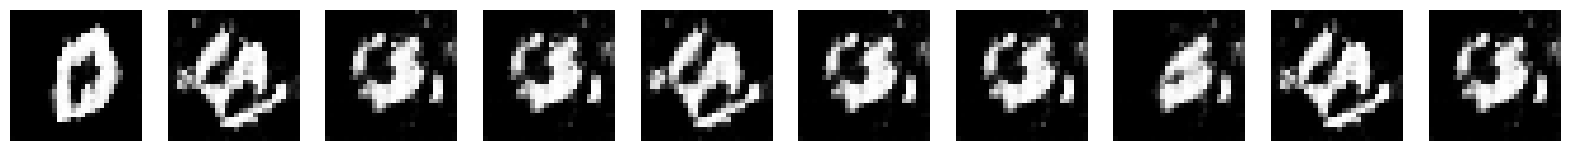

[51/100][0/235] Loss_D: 0.3799 Loss_G: 0.2826 D(x): 0.8907 D(G(z1)): 0.0283 / D(G(z2)): 0.8526
[51/100][50/235] Loss_D: 0.3660 Loss_G: 0.4452 D(x): 0.8791 D(G(z1)): 0.0124 / D(G(z2)): 0.8427
[51/100][100/235] Loss_D: 0.3535 Loss_G: 0.2525 D(x): 0.8795 D(G(z1)): 0.0075 / D(G(z2)): 0.8776
[51/100][150/235] Loss_D: 0.3537 Loss_G: 0.3974 D(x): 0.8959 D(G(z1)): 0.0062 / D(G(z2)): 0.8709
[51/100][200/235] Loss_D: 0.3466 Loss_G: 0.5139 D(x): 0.8917 D(G(z1)): 0.0047 / D(G(z2)): 0.8406
[52/100][0/235] Loss_D: 0.3667 Loss_G: 0.3196 D(x): 0.8728 D(G(z1)): 0.0071 / D(G(z2)): 0.8652
[52/100][50/235] Loss_D: 0.3506 Loss_G: 0.4178 D(x): 0.8937 D(G(z1)): 0.0045 / D(G(z2)): 0.8722
[52/100][100/235] Loss_D: 0.3757 Loss_G: 0.2616 D(x): 0.8811 D(G(z1)): 0.0238 / D(G(z2)): 0.8926
[52/100][150/235] Loss_D: 0.3572 Loss_G: 0.3787 D(x): 0.8914 D(G(z1)): 0.0128 / D(G(z2)): 0.8743
[52/100][200/235] Loss_D: 0.3726 Loss_G: 0.3034 D(x): 0.8865 D(G(z1)): 0.0104 / D(G(z2)): 0.8759
[53/100][0/235] Loss_D: 0.3534 Loss_

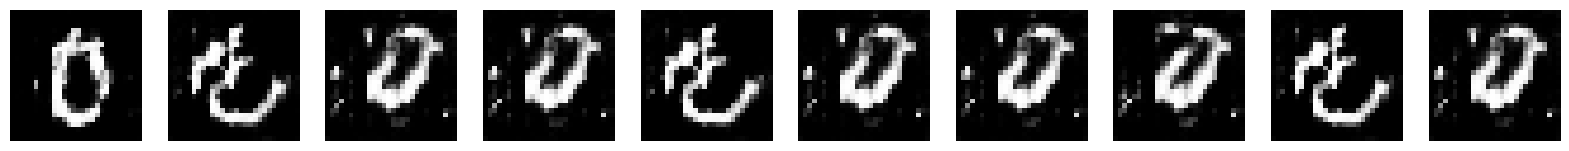

[61/100][0/235] Loss_D: 0.3608 Loss_G: 0.3853 D(x): 0.8824 D(G(z1)): 0.0095 / D(G(z2)): 0.8341
[61/100][50/235] Loss_D: 0.3517 Loss_G: 0.2951 D(x): 0.8962 D(G(z1)): 0.0133 / D(G(z2)): 0.8732
[61/100][100/235] Loss_D: 0.3491 Loss_G: 0.4931 D(x): 0.8973 D(G(z1)): 0.0059 / D(G(z2)): 0.8666
[61/100][150/235] Loss_D: 0.3639 Loss_G: 0.2833 D(x): 0.8805 D(G(z1)): 0.0064 / D(G(z2)): 0.8834
[61/100][200/235] Loss_D: 0.3573 Loss_G: 0.2098 D(x): 0.8925 D(G(z1)): 0.0074 / D(G(z2)): 0.9241
[62/100][0/235] Loss_D: 0.3502 Loss_G: 0.4800 D(x): 0.8937 D(G(z1)): 0.0094 / D(G(z2)): 0.8517
[62/100][50/235] Loss_D: 0.3539 Loss_G: 0.3392 D(x): 0.8868 D(G(z1)): 0.0103 / D(G(z2)): 0.8812
[62/100][100/235] Loss_D: 0.3684 Loss_G: 0.4329 D(x): 0.8853 D(G(z1)): 0.0146 / D(G(z2)): 0.8565
[62/100][150/235] Loss_D: 0.3588 Loss_G: 0.1997 D(x): 0.8943 D(G(z1)): 0.0066 / D(G(z2)): 0.9187
[62/100][200/235] Loss_D: 0.3757 Loss_G: 0.2202 D(x): 0.8735 D(G(z1)): 0.0056 / D(G(z2)): 0.9074
[63/100][0/235] Loss_D: 0.3855 Loss_

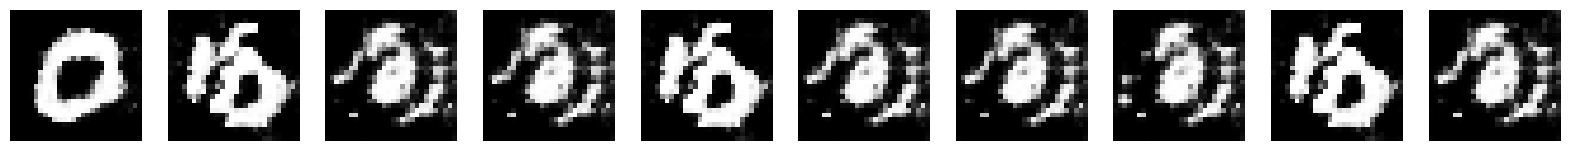

[71/100][0/235] Loss_D: 0.3838 Loss_G: 0.5108 D(x): 0.8722 D(G(z1)): 0.0107 / D(G(z2)): 0.8496
[71/100][50/235] Loss_D: 0.3414 Loss_G: 0.2694 D(x): 0.9010 D(G(z1)): 0.0043 / D(G(z2)): 0.9113
[71/100][100/235] Loss_D: 0.3624 Loss_G: 0.4305 D(x): 0.8833 D(G(z1)): 0.0113 / D(G(z2)): 0.8385
[71/100][150/235] Loss_D: 0.3571 Loss_G: 0.3402 D(x): 0.8974 D(G(z1)): 0.0058 / D(G(z2)): 0.8837
[71/100][200/235] Loss_D: 0.3622 Loss_G: 0.2288 D(x): 0.8878 D(G(z1)): 0.0165 / D(G(z2)): 0.8975
[72/100][0/235] Loss_D: 0.3551 Loss_G: 0.3056 D(x): 0.8925 D(G(z1)): 0.0104 / D(G(z2)): 0.9138
[72/100][50/235] Loss_D: 0.3619 Loss_G: 0.3857 D(x): 0.9043 D(G(z1)): 0.0220 / D(G(z2)): 0.8565
[72/100][100/235] Loss_D: 0.3424 Loss_G: 0.3706 D(x): 0.8944 D(G(z1)): 0.0061 / D(G(z2)): 0.8737
[72/100][150/235] Loss_D: 0.3468 Loss_G: 0.4638 D(x): 0.8916 D(G(z1)): 0.0097 / D(G(z2)): 0.8673
[72/100][200/235] Loss_D: 0.3642 Loss_G: 0.3210 D(x): 0.8902 D(G(z1)): 0.0081 / D(G(z2)): 0.8906
[73/100][0/235] Loss_D: 0.3565 Loss_

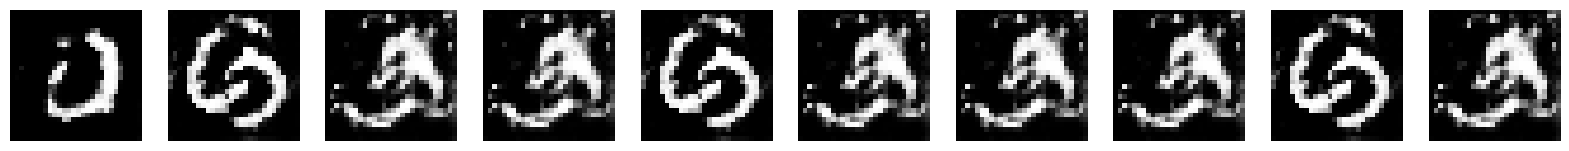

[81/100][0/235] Loss_D: 0.3756 Loss_G: 0.3419 D(x): 0.8993 D(G(z1)): 0.0231 / D(G(z2)): 0.8922
[81/100][50/235] Loss_D: 0.3584 Loss_G: 0.3044 D(x): 0.8760 D(G(z1)): 0.0066 / D(G(z2)): 0.9023
[81/100][100/235] Loss_D: 0.3657 Loss_G: 0.3832 D(x): 0.8986 D(G(z1)): 0.0129 / D(G(z2)): 0.8593
[81/100][150/235] Loss_D: 0.3881 Loss_G: 0.4379 D(x): 0.8752 D(G(z1)): 0.0126 / D(G(z2)): 0.8539
[81/100][200/235] Loss_D: 0.3904 Loss_G: 0.1428 D(x): 0.8850 D(G(z1)): 0.0149 / D(G(z2)): 0.9265
[82/100][0/235] Loss_D: 0.3675 Loss_G: 0.3520 D(x): 0.8790 D(G(z1)): 0.0055 / D(G(z2)): 0.9011
[82/100][50/235] Loss_D: 0.3531 Loss_G: 0.4096 D(x): 0.8957 D(G(z1)): 0.0080 / D(G(z2)): 0.8664
[82/100][100/235] Loss_D: 0.3481 Loss_G: 0.2824 D(x): 0.8867 D(G(z1)): 0.0048 / D(G(z2)): 0.8993
[82/100][150/235] Loss_D: 0.3466 Loss_G: 0.3083 D(x): 0.8962 D(G(z1)): 0.0067 / D(G(z2)): 0.9034
[82/100][200/235] Loss_D: 0.3594 Loss_G: 0.3045 D(x): 0.8881 D(G(z1)): 0.0147 / D(G(z2)): 0.9007
[83/100][0/235] Loss_D: 0.3450 Loss_

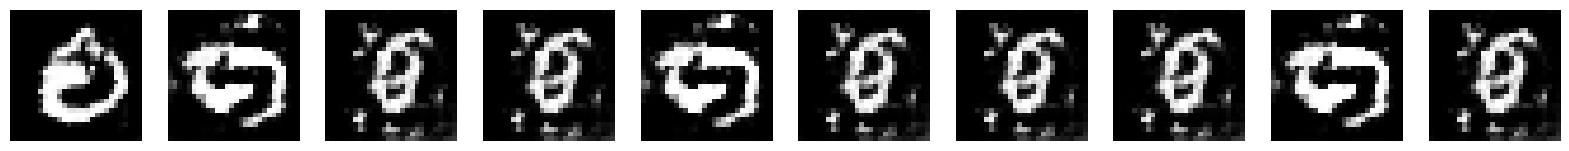

[91/100][0/235] Loss_D: 0.3579 Loss_G: 0.5842 D(x): 0.8859 D(G(z1)): 0.0143 / D(G(z2)): 0.8126
[91/100][50/235] Loss_D: 0.3520 Loss_G: 0.4997 D(x): 0.8903 D(G(z1)): 0.0080 / D(G(z2)): 0.8448
[91/100][100/235] Loss_D: 0.3521 Loss_G: 0.2382 D(x): 0.9019 D(G(z1)): 0.0126 / D(G(z2)): 0.9093
[91/100][150/235] Loss_D: 0.3812 Loss_G: 0.2540 D(x): 0.8749 D(G(z1)): 0.0135 / D(G(z2)): 0.8817
[91/100][200/235] Loss_D: 0.3634 Loss_G: 0.4009 D(x): 0.8837 D(G(z1)): 0.0084 / D(G(z2)): 0.8523
[92/100][0/235] Loss_D: 0.3588 Loss_G: 0.3159 D(x): 0.8850 D(G(z1)): 0.0046 / D(G(z2)): 0.8931
[92/100][50/235] Loss_D: 0.3776 Loss_G: 0.2370 D(x): 0.8802 D(G(z1)): 0.0148 / D(G(z2)): 0.9045
[92/100][100/235] Loss_D: 0.3634 Loss_G: 0.3117 D(x): 0.8874 D(G(z1)): 0.0129 / D(G(z2)): 0.8820
[92/100][150/235] Loss_D: 0.3639 Loss_G: 0.3172 D(x): 0.8916 D(G(z1)): 0.0166 / D(G(z2)): 0.8984
[92/100][200/235] Loss_D: 0.3587 Loss_G: 0.3105 D(x): 0.8886 D(G(z1)): 0.0087 / D(G(z2)): 0.8958
[93/100][0/235] Loss_D: 0.3521 Loss_

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# 하이퍼파라미터 설정
BATCH_SIZE = 256
lr_D = 0.0002  # 판별자의 학습률
lr_G = 0.0001  # 생성자의 학습률
EPOCHS = 100
noise_dim = 200


# 옵티마이저 설정
D = CondDiscriminator().to(device)
G = CondGenerator().to(device)
D_optimizer = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.999))

# 손실 함수
criterion = nn.BCELoss()

# 훈련
G.train()
D.train()

train_hist = {'D_losses': [], 'G_losses': []}

for epoch in range(EPOCHS):
    D_losses = []
    G_losses = []

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 진짜 이미지에 대한 판별자의 손실 계산
        D.zero_grad()
        real_labels = torch.full((images.size(0),), 0.9, device=device)  # 라벨 스무딩 적용
        outputs = D(images, labels).view(-1)
        D_loss_real = criterion(outputs, real_labels)
        D_x = outputs.mean().item()

        # 가짜 이미지 생성 및 판별자 손실 계산
        noise = torch.randn(images.size(0), noise_dim, device=device)
        fake_labels = torch.randint(0, 10, (images.size(0),), device=device)
        fake_images = G(noise, fake_labels)
        fake_outputs = D(fake_images.detach(), fake_labels).view(-1)
        fake_labels = torch.zeros(images.size(0), device=device)  # 가짜 이미지 레이블
        D_loss_fake = criterion(fake_outputs, fake_labels)
        D_G_z1 = fake_outputs.mean().item()

        # 판별자 업데이트
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        # 생성자의 손실 계산 및 업데이트
        G.zero_grad()
        labels = torch.full((images.size(0),), 1.0, device=device, dtype=torch.float)  # 생성자에게는 모두 진짜라고 속임
        outputs = D(fake_images, fake_labels).view(-1)
        G_loss = criterion(outputs, labels)
        G_loss.backward()
        G_optimizer.step()
        D_G_z2 = outputs.mean().item()

        if i % 50 == 0:
            print(f'[{epoch}/{EPOCHS}][{i}/{len(train_loader)}] Loss_D: {D_loss.item():.4f} Loss_G: {G_loss.item():.4f} D(x): {D_x:.4f} D(G(z1)): {D_G_z1:.4f} / D(G(z2)): {D_G_z2:.4f}')

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))

    # 5 에포크마다 생성된 이미지 시각화
    if epoch % 10 == 0:
        with torch.no_grad():
            noise = torch.randn(10, noise_dim, device=device)
            labels = torch.arange(10, device=device)  # 0부터 9까지의 레이블
            fake_images = G(noise, labels).cpu()
            fig, axes = plt.subplots(1, 10, figsize=(20, 2))
            for i in range(10):
                axes[i].imshow(fake_images[i].squeeze().detach().numpy(), cmap='gray')
                axes[i].axis('off')
            plt.show()

print('Training Finished!')


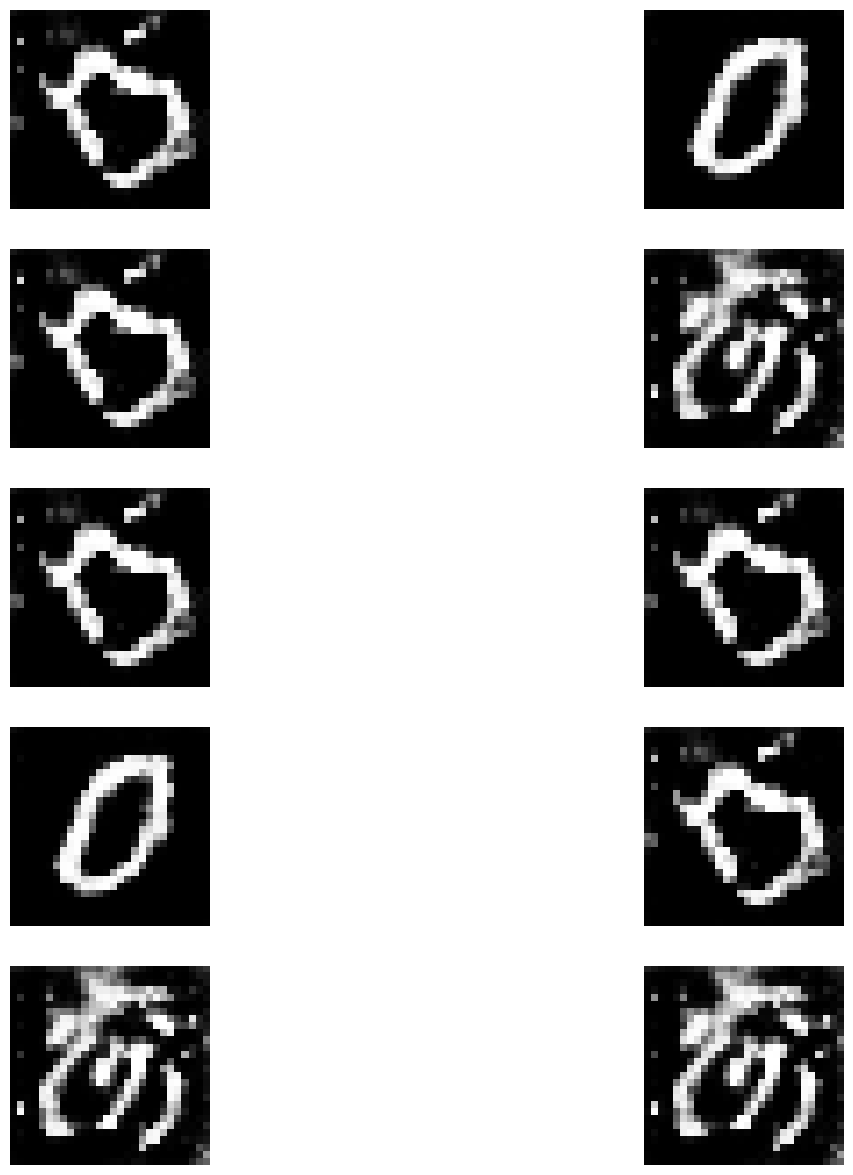

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

# 10개의 조건 설정 (0에서 9까지 무작위 숫자)
condition = torch.randint(0, 10, (10,), device=device)

# Generator 테스트
G.eval()  # 모델을 평가 모드로 설정
noises = torch.randn(10, 200, device=device)  # 10개의 노이즈 벡터 생성
# generated_images = G(noises, condition).cpu().detach().numpy().squeeze()
generated_image = G(noises,condition).cpu().detach().numpy().squeeze()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()

## 학습코드 try 06 (TODO 02 + 03)

[0/50][0/235] Loss_D: 1.3908 Loss_G: 0.7062 D(x): 0.5016 D(G(z1)): 0.5024 / D(G(z2)): 0.4939
[0/50][50/235] Loss_D: 0.3905 Loss_G: 2.7244 D(x): 0.8496 D(G(z1)): 0.0429 / D(G(z2)): 0.0671
[0/50][100/235] Loss_D: 0.3435 Loss_G: 3.9818 D(x): 0.8908 D(G(z1)): 0.0072 / D(G(z2)): 0.0191
[0/50][150/235] Loss_D: 0.3388 Loss_G: 4.4183 D(x): 0.8982 D(G(z1)): 0.0037 / D(G(z2)): 0.0125
[0/50][200/235] Loss_D: 0.3949 Loss_G: 2.3970 D(x): 0.8224 D(G(z1)): 0.0309 / D(G(z2)): 0.0966


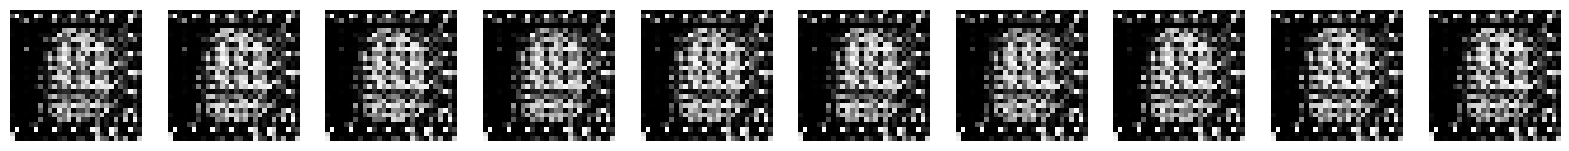

[1/50][0/235] Loss_D: 0.3510 Loss_G: 3.8405 D(x): 0.8800 D(G(z1)): 0.0079 / D(G(z2)): 0.0233
[1/50][50/235] Loss_D: 0.3423 Loss_G: 4.6894 D(x): 0.8963 D(G(z1)): 0.0043 / D(G(z2)): 0.0098
[1/50][100/235] Loss_D: 0.4391 Loss_G: 2.4179 D(x): 0.7936 D(G(z1)): 0.0554 / D(G(z2)): 0.0960
[1/50][150/235] Loss_D: 0.3720 Loss_G: 3.2523 D(x): 0.8635 D(G(z1)): 0.0240 / D(G(z2)): 0.0426
[1/50][200/235] Loss_D: 0.3525 Loss_G: 4.0447 D(x): 0.8903 D(G(z1)): 0.0103 / D(G(z2)): 0.0199
[2/50][0/235] Loss_D: 0.3482 Loss_G: 4.4251 D(x): 0.8967 D(G(z1)): 0.0080 / D(G(z2)): 0.0136
[2/50][50/235] Loss_D: 0.3458 Loss_G: 4.6059 D(x): 0.8988 D(G(z1)): 0.0056 / D(G(z2)): 0.0112
[2/50][100/235] Loss_D: 0.3431 Loss_G: 4.7228 D(x): 0.8942 D(G(z1)): 0.0044 / D(G(z2)): 0.0099
[2/50][150/235] Loss_D: 0.3427 Loss_G: 4.8979 D(x): 0.9053 D(G(z1)): 0.0035 / D(G(z2)): 0.0084
[2/50][200/235] Loss_D: 0.3401 Loss_G: 5.0248 D(x): 0.8903 D(G(z1)): 0.0029 / D(G(z2)): 0.0074
[3/50][0/235] Loss_D: 0.3394 Loss_G: 5.1680 D(x): 0.8977

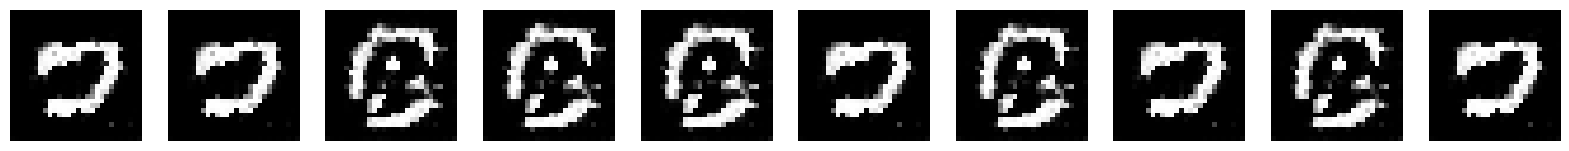

[11/50][0/235] Loss_D: 0.4454 Loss_G: 0.6019 D(x): 0.8451 D(G(z1)): 0.0402 / D(G(z2)): 0.6288
[11/50][50/235] Loss_D: 0.4191 Loss_G: 0.8691 D(x): 0.8721 D(G(z1)): 0.0379 / D(G(z2)): 0.5817
[11/50][100/235] Loss_D: 0.4751 Loss_G: 0.6069 D(x): 0.8268 D(G(z1)): 0.0484 / D(G(z2)): 0.5879
[11/50][150/235] Loss_D: 0.4767 Loss_G: 0.6416 D(x): 0.8607 D(G(z1)): 0.0667 / D(G(z2)): 0.5839
[11/50][200/235] Loss_D: 0.5057 Loss_G: 0.6875 D(x): 0.8410 D(G(z1)): 0.0690 / D(G(z2)): 0.5420
[12/50][0/235] Loss_D: 0.4679 Loss_G: 0.7297 D(x): 0.8403 D(G(z1)): 0.0505 / D(G(z2)): 0.5352
[12/50][50/235] Loss_D: 0.5247 Loss_G: 0.6058 D(x): 0.8159 D(G(z1)): 0.0615 / D(G(z2)): 0.5915
[12/50][100/235] Loss_D: 0.4889 Loss_G: 0.8271 D(x): 0.8529 D(G(z1)): 0.0762 / D(G(z2)): 0.5310
[12/50][150/235] Loss_D: 0.4564 Loss_G: 0.6593 D(x): 0.8686 D(G(z1)): 0.0659 / D(G(z2)): 0.5947
[12/50][200/235] Loss_D: 0.4446 Loss_G: 0.7741 D(x): 0.8666 D(G(z1)): 0.0439 / D(G(z2)): 0.5449
[13/50][0/235] Loss_D: 0.4411 Loss_G: 0.6118 D

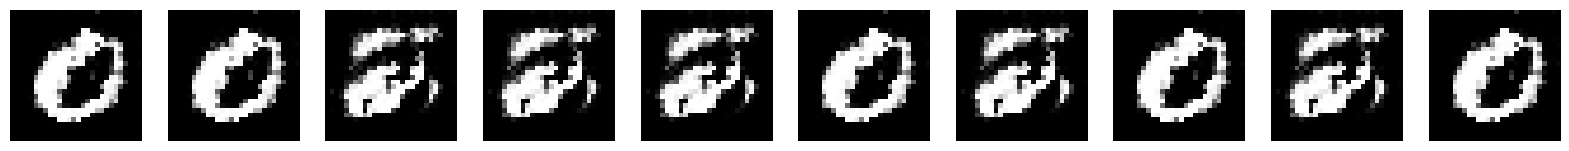

[21/50][0/235] Loss_D: 0.4097 Loss_G: 0.9894 D(x): 0.8742 D(G(z1)): 0.0271 / D(G(z2)): 0.5402
[21/50][50/235] Loss_D: 0.3976 Loss_G: 0.8786 D(x): 0.8837 D(G(z1)): 0.0296 / D(G(z2)): 0.5654
[21/50][100/235] Loss_D: 0.4471 Loss_G: 1.1197 D(x): 0.8639 D(G(z1)): 0.0532 / D(G(z2)): 0.4760
[21/50][150/235] Loss_D: 0.4328 Loss_G: 0.7799 D(x): 0.8654 D(G(z1)): 0.0372 / D(G(z2)): 0.5761
[21/50][200/235] Loss_D: 0.4314 Loss_G: 0.8365 D(x): 0.8854 D(G(z1)): 0.0539 / D(G(z2)): 0.5215
[22/50][0/235] Loss_D: 0.4448 Loss_G: 0.7770 D(x): 0.8611 D(G(z1)): 0.0436 / D(G(z2)): 0.5299
[22/50][50/235] Loss_D: 0.4535 Loss_G: 0.9952 D(x): 0.8373 D(G(z1)): 0.0350 / D(G(z2)): 0.4833
[22/50][100/235] Loss_D: 0.4102 Loss_G: 0.8890 D(x): 0.8851 D(G(z1)): 0.0322 / D(G(z2)): 0.5402
[22/50][150/235] Loss_D: 0.4003 Loss_G: 0.9753 D(x): 0.8708 D(G(z1)): 0.0200 / D(G(z2)): 0.5840
[22/50][200/235] Loss_D: 0.4785 Loss_G: 0.8423 D(x): 0.8200 D(G(z1)): 0.0610 / D(G(z2)): 0.5338
[23/50][0/235] Loss_D: 0.4258 Loss_G: 0.8191 D

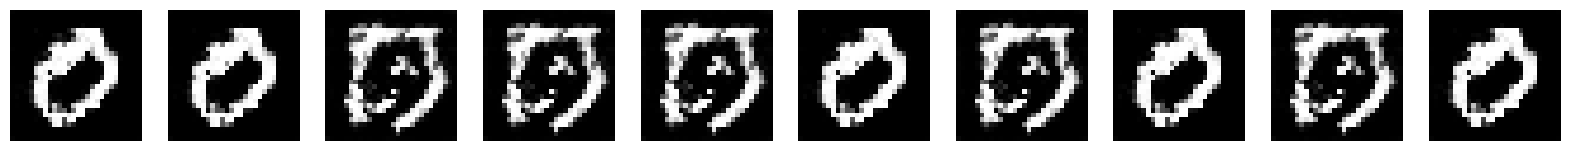

[31/50][0/235] Loss_D: 0.3984 Loss_G: 0.8590 D(x): 0.8703 D(G(z1)): 0.0263 / D(G(z2)): 0.5832
[31/50][50/235] Loss_D: 0.4239 Loss_G: 0.7930 D(x): 0.8604 D(G(z1)): 0.0400 / D(G(z2)): 0.5887
[31/50][100/235] Loss_D: 0.3941 Loss_G: 0.7065 D(x): 0.8713 D(G(z1)): 0.0160 / D(G(z2)): 0.6334
[31/50][150/235] Loss_D: 0.3942 Loss_G: 0.9298 D(x): 0.8665 D(G(z1)): 0.0274 / D(G(z2)): 0.5485
[31/50][200/235] Loss_D: 0.4065 Loss_G: 0.6175 D(x): 0.8773 D(G(z1)): 0.0295 / D(G(z2)): 0.6694
[32/50][0/235] Loss_D: 0.4182 Loss_G: 0.8245 D(x): 0.8529 D(G(z1)): 0.0336 / D(G(z2)): 0.5869
[32/50][50/235] Loss_D: 0.4014 Loss_G: 0.7573 D(x): 0.8745 D(G(z1)): 0.0301 / D(G(z2)): 0.6066
[32/50][100/235] Loss_D: 0.3850 Loss_G: 1.0440 D(x): 0.8683 D(G(z1)): 0.0182 / D(G(z2)): 0.5562
[32/50][150/235] Loss_D: 0.3791 Loss_G: 1.3696 D(x): 0.8786 D(G(z1)): 0.0113 / D(G(z2)): 0.5212
[32/50][200/235] Loss_D: 0.4054 Loss_G: 0.9808 D(x): 0.8618 D(G(z1)): 0.0266 / D(G(z2)): 0.5644
[33/50][0/235] Loss_D: 0.4250 Loss_G: 0.6179 D

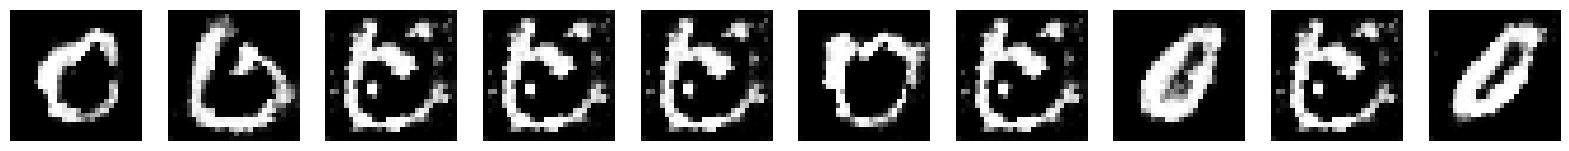

[41/50][0/235] Loss_D: 0.3795 Loss_G: 0.5506 D(x): 0.8808 D(G(z1)): 0.0301 / D(G(z2)): 0.7473
[41/50][50/235] Loss_D: 0.4180 Loss_G: 0.2661 D(x): 0.8625 D(G(z1)): 0.0299 / D(G(z2)): 0.7963
[41/50][100/235] Loss_D: 0.4238 Loss_G: 0.2425 D(x): 0.8688 D(G(z1)): 0.0325 / D(G(z2)): 0.8394
[41/50][150/235] Loss_D: 0.4272 Loss_G: 0.6021 D(x): 0.8469 D(G(z1)): 0.0253 / D(G(z2)): 0.6467
[41/50][200/235] Loss_D: 0.4491 Loss_G: 0.4604 D(x): 0.8490 D(G(z1)): 0.0282 / D(G(z2)): 0.7369
[42/50][0/235] Loss_D: 0.3802 Loss_G: 0.2126 D(x): 0.8833 D(G(z1)): 0.0240 / D(G(z2)): 0.8662
[42/50][50/235] Loss_D: 0.3960 Loss_G: 0.3068 D(x): 0.8694 D(G(z1)): 0.0238 / D(G(z2)): 0.8257
[42/50][100/235] Loss_D: 0.3680 Loss_G: 0.2756 D(x): 0.8839 D(G(z1)): 0.0160 / D(G(z2)): 0.8614
[42/50][150/235] Loss_D: 0.3944 Loss_G: 0.6510 D(x): 0.8719 D(G(z1)): 0.0228 / D(G(z2)): 0.6980
[42/50][200/235] Loss_D: 0.4037 Loss_G: 0.6059 D(x): 0.8640 D(G(z1)): 0.0274 / D(G(z2)): 0.7050
[43/50][0/235] Loss_D: 0.4276 Loss_G: 0.4799 D

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# 하이퍼파라미터 설정
BATCH_SIZE = 256
lr_D = 0.0001  # 판별자의 학습률
lr_G = 0.0001  # 생성자의 학습률
EPOCHS = 50
noise_dim = 200


# 옵티마이저 설정
D = CondDiscriminator().to(device)
G = CondGenerator().to(device)
D_optimizer = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.999))

# 손실 함수
criterion = nn.BCELoss()

# 훈련
G.train()
D.train()

train_hist = {'D_losses': [], 'G_losses': []}

for epoch in range(EPOCHS):
    D_losses = []
    G_losses = []

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 진짜 이미지에 대한 판별자의 손실 계산
        D.zero_grad()
        real_labels = torch.full((images.size(0),), 0.9, device=device)  # 라벨 스무딩 적용
        outputs = D(images, labels).view(-1)
        D_loss_real = criterion(outputs, real_labels)
        D_x = outputs.mean().item()

        # 가짜 이미지 생성 및 판별자 손실 계산
        noise = torch.randn(images.size(0), noise_dim, device=device)
        fake_labels = torch.randint(0, 10, (images.size(0),), device=device)
        fake_images = G(noise, fake_labels)
        fake_outputs = D(fake_images.detach(), fake_labels).view(-1)
        fake_labels = torch.zeros(images.size(0), device=device)  # 가짜 이미지 레이블
        D_loss_fake = criterion(fake_outputs, fake_labels)
        D_G_z1 = fake_outputs.mean().item()

        # 판별자 업데이트
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        # 생성자의 손실 계산 및 업데이트
        G.zero_grad()
        labels = torch.full((images.size(0),), 1.0, device=device, dtype=torch.float)  # 생성자에게는 모두 진짜라고 속임
        outputs = D(fake_images, fake_labels).view(-1)
        G_loss = criterion(outputs, labels)
        G_loss.backward()
        G_optimizer.step()
        D_G_z2 = outputs.mean().item()

        if i % 50 == 0:
            print(f'[{epoch}/{EPOCHS}][{i}/{len(train_loader)}] Loss_D: {D_loss.item():.4f} Loss_G: {G_loss.item():.4f} D(x): {D_x:.4f} D(G(z1)): {D_G_z1:.4f} / D(G(z2)): {D_G_z2:.4f}')

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))

    # 5 에포크마다 생성된 이미지 시각화
    if epoch % 10 == 0:
        with torch.no_grad():
            noise = torch.randn(10, noise_dim, device=device)
            labels = torch.arange(10, device=device)  # 0부터 9까지의 레이블
            fake_images = G(noise, labels).cpu()
            fig, axes = plt.subplots(1, 10, figsize=(20, 2))
            for i in range(10):
                axes[i].imshow(fake_images[i].squeeze().detach().numpy(), cmap='gray')
                axes[i].axis('off')
            plt.show()

print('Training Finished!')


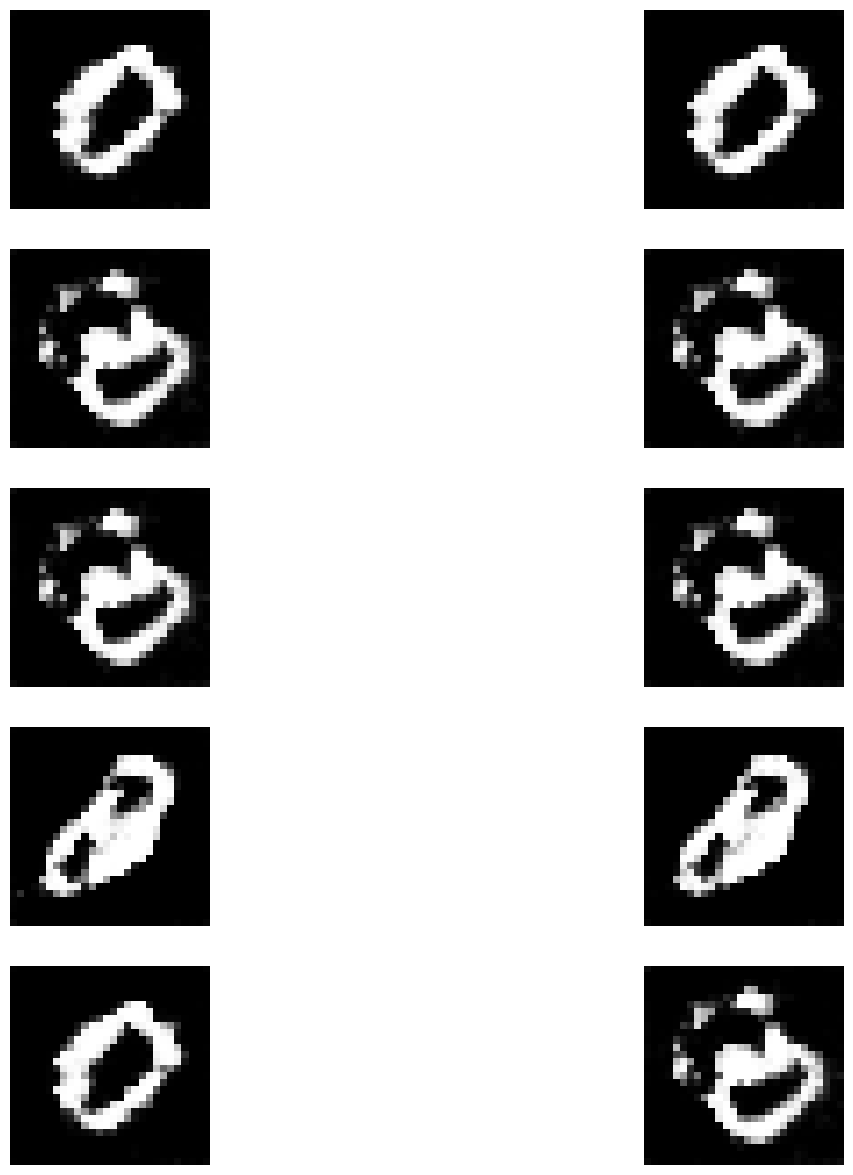

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

# 10개의 조건 설정 (0에서 9까지 무작위 숫자)
condition = torch.randint(0, 10, (10,), device=device)

# Generator 테스트
G.eval()  # 모델을 평가 모드로 설정
noises = torch.randn(10, 200, device=device)  # 10개의 노이즈 벡터 생성
# generated_images = G(noises, condition).cpu().detach().numpy().squeeze()
generated_image = G(noises,condition).cpu().detach().numpy().squeeze()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()